# Piezómetros Mar Menor

In [2]:
import getpass
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import psycopg2
import pandas as pd
import pandas.io.sql as psql
import ipywidgets as widgets

%matplotlib widget

import sys
sys.path.append(r'C:\Users\solis\Documents\DEV\python3\common')
import plot_with_mpl as p

## Reload module plot_with_mpl

In [17]:
# Run only if I edit C:\Users\solis\Documents\DEV\python3\common\plot_with_mpl.py
from importlib import reload 
import plot_with_mpl
reload(plot_with_mpl)
import plot_with_mpl as p

## Figure parameters

In [5]:
x_cm = 11
x_in, y_in = p.fig_size_cm_2_in(x_cm)
print(x_in, y_in)

4.330708661417323 3.248031496062992


In [6]:
mpl.rcdefaults()
plt.rc('figure', figsize=(x_in, y_in), dpi=80)
plt.rc('font', size=8)
plt.rc('axes', labelsize=8, titlesize= 9, grid=True)
plt.rc('axes.spines', right=False, top=False)
plt.rc('xtick', direction='out', top=False)
plt.rc('ytick', direction='out', right=False)
plt.rc('lines', linewidth=0.8, linestyle='-', marker='.', markersize=4)
plt.rc('legend', fontsize=8, framealpha=0.5, loc='best')

plt.subplots_adjust(hspace=0.1, bottom=0.16, top=0.87)
plt.close()

## Functions

In [7]:
def df_piezo_pluvio_get(df_pz_plv, piez1, outf=None):
    """
    
    parameters
    df_pz_plv: dataframe
        relationship between each piezometer and its nearest rain gauge
    piez1: str
        a piezometer in df_pz_plv
    returns
    df_cnp: dataframe
        heads data of piez1
    df_plv: dataframe
        precipitacion data of rain gauge related with piez1
    outf: str
        file output
    """

    # piezometric data
    select = \
    """
    select t.id, t.fecha , t.v 
    from saih.tsd t 
    where t.id = %s and t.var = 'e10' 
    order by t.fecha
    """
    df_cnp = psql.read_sql(select, con, params=(piez1,))
    if len(df_cnp) == 0:
        raise ValueError(f'el piezómetro {piez1} no tiene datos')

    # rain gauge related with piez1
    pluvio1 = 'Not found'
    for row in zip(df_pz_plv['piez'],df_pz_plv['pluvio']):
        if row[0] == piez1:
            pluvio1 = row[1]
            exit
    if pluvio1 == 'Not found':
        raise ValueError(f'el piezómetro {piez1} no tiene pluviómetro asociado!')
    
    # precipitation data
    select = \
    """
    select t.id, t.fecha , t.v 
    from saih.tsd t 
    where t.id = %s and t.var = 'p01' and t.v>0 and t.fecha >= '2019-10-01'
    order by fecha
    """
    df_plv = psql.read_sql(select, con, params=(pluvio1,))
    if len(df_plv) == 0:
        raise ValueError(f'el pluviómetro {pluvio1} no tiene datos')
    
    return df_cnp, df_plv 

## Database

In [8]:
db = getpass.getpass('DB: ')
user = getpass.getpass('User: ')
passw = getpass.getpass('Password: ')
con = psycopg2.connect(database=db, user=user, password=passw)
cur = con.cursor()

DB:  ···
User:  ········
Password:  ··


## Data

### Desembocadura Albujón

In [9]:
# desembocadura albujón
select = \
"""
select t.fecha::date fecha, (avg(t.v)) q
from saih.tsh t 
where id = '06a18' and t.var='q01'
group by t.fecha::date
order by t.fecha::date
"""
df_alb18 = psql.read_sql(select, con)

In [7]:
df_alb18.head()

,fecha,q
0,2021-01-12,0.183242
1,2021-01-13,0.184608
2,2021-01-14,0.177271
3,2021-01-15,0.174525
4,2021-01-16,0.172125


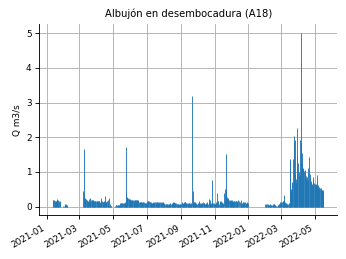

In [10]:
p.stem_1(df_alb18['fecha'], df_alb18['q'], 'Albujón en desembocadura (A18)', 'Q m3/s')

### Piezómetros

#### Pluviómetros más próximos a cada piezómetro

In [12]:
select = \
"""
with plvs as (
select t1.id, t1.name, t1.geom
from saih.puntos t1 
	join saih.tsd t2 using(id)
where var = 'p01'
group by t1.id, t1.name
),
pzs as (
select t1.id, t1.name, t1.geom
from saih.puntos t1 
	join saih.tsd t2 using(id)
where var = 'e10'
group by t1.id, t1.name
)
select t1.id piez, 
	split_part(min(concat(st_distance(t1.geom, t2.geom), ' - ', t2.id)), ' - ', 2) pluvio, 
	split_part(min(concat(st_distance(t1.geom, t2.geom), ' - ', t2.id)), ' - ', 1) distance
from pzs t1, plvs t2 
group by t1.id
order by t1.id 
"""
df_pz_plv = psql.read_sql(select, con)
df_pz_plv.head()

,piez,pluvio,distance
0,06z01,06a01,15678.747526508614
1,06z02,06a01,14901.546362710147
2,06z03,06p02,16496.78683865437
3,06z05,06a04,598007.1926398545
4,06z06,06p02,12304.178152156283


In [13]:
piezos = df_pz_plv['piez'].to_numpy()
piez1 = widgets.Select(
    options=piezos,
    value=piezos[0],
    # rows=10,
    description='Piezómetros:',
    disabled=False
)

In [14]:
display(piez1)

Select(description='Piezómetros:', options=('06z01', '06z02', '06z03', '06z05', '06z06', '06z07', '06z08', '06…

Piezómetro seleccionado:  06z02


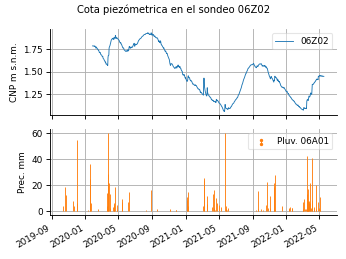

In [20]:
print('Piezómetro seleccionado: ', piez1.value)
df_cnp, df_plv = df_piezo_pluvio_get(df_pz_plv, piez1.value)
p.subplot_nv([df_cnp['fecha'], df_plv['fecha']],
             [df_cnp['v'], df_plv['v']],
             [f'{piez1.value.upper()}', f'Pluv. {df_plv["id"][0].upper()}'],
             f'Cota piezómetrica en el sondeo {piez1.value.upper()}', 
             ['CNP m s.n.m.', 'Prec. mm'])

#### Grabar todos los piezómetros

06z01
06z02
06z03
06z05
06z06
06z07
06z08
06z09
06z10
06z11
06z12
06z13
06z14
06z15
06z16
06z17
06z18
06z19
06z20


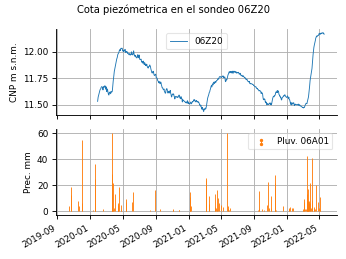

In [19]:
dir_out = r'H:\LSGB\20220503_Mar_Menor\xy\pz_costeros'
for pz1 in piezos:
    print(pz1)
    fout = join(dir_out, f'{pz1}.png')
    df_cnp, df_plv = df_piezo_pluvio_get(df_pz_plv, pz1)
    p.subplot_nv([df_cnp['fecha'], df_plv['fecha']],
                 [df_cnp['v'], df_plv['v']],
                 [f'{pz1.upper()}', f'Pluv. {df_plv["id"][0].upper()}'],
                 f'Cota piezómetrica en el sondeo {pz1.upper()}', 
                 ['CNP m s.n.m.', 'Prec. mm'], fout=fout)